# Boosting

Boosting方法是使用同一组数据集进行反复学习，得到一系列简单模型，然后组合这些模型构成一个预测性能十分强大的机器学习模型。显然，Boosting思想提高最终的预测效果是通过不断减少偏差的形式，与Bagging有着本质的不同。在Boosting这一大类方法中，笔者主要介绍两类常用的Boosting方式：Adaptive Boosting 和 Gradient Boosting 以及它们的变体Xgboost、LightGBM以及Catboost。

**Adaboost的基本原理**                             

对于Adaboost来说，解决上述的两个问题的方式是：1. 提高那些被前一轮分类器错误分类的样本的权重，而降低那些被正确分类的样本的权重。这样一来，那些在上一轮分类器中没有得到正确分类的样本，由于其权重的增大而在后一轮的训练中“备受关注”。2. 各个弱分类器的组合是通过采取加权多数表决的方式，具体来说，加大分类错误率低的弱分类器的权重，因为这些分类器能更好地完成分类任务，而减小分类错误率较大的弱分类器的权重，使其在表决中起较小的作用。                          
现在，我们来具体介绍Adaboost算法：(参考李航老师的《统计学习方法》)                       
假设给定一个二分类的训练数据集：$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}$，其中每个样本点由特征与类别组成。特征$x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}$，类别$y_{i} \in \mathcal{Y}=\{-1,+1\}$，$\mathcal{X}$是特征空间，$ \mathcal{Y}$是类别集合，输出最终分类器$G(x)$。Adaboost算法如下：                 
(1) 初始化训练数据的分布：$D_{1}=\left(w_{11}, \cdots, w_{1 i}, \cdots, w_{1 N}\right), \quad w_{1 i}=\frac{1}{N}, \quad i=1,2, \cdots, N$                       
(2) 对于m=1,2,...,M            
   - 使用具有权值分布$D_m$的训练数据集进行学习，得到基本分类器：$G_{m}(x): \mathcal{X} \rightarrow\{-1,+1\}$                  
   - 计算$G_m(x)$在训练集上的分类误差率$e_{m}=\sum_{i=1}^{N} P\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)=\sum_{i=1}^{N} w_{m i} I\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)$                   
   - 计算$G_m(x)$的系数$\alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}$，这里的log是自然对数ln                         
   - 更新训练数据集的权重分布                
   $$
   \begin{array}{c}
   D_{m+1}=\left(w_{m+1,1}, \cdots, w_{m+1, i}, \cdots, w_{m+1, N}\right) \\
   w_{m+1, i}=\frac{w_{m i}}{Z_{m}} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right), \quad i=1,2, \cdots, N
   \end{array}
   $$                       
   这里的$Z_m$是规范化因子，使得$D_{m+1}$称为概率分布，$Z_{m}=\sum_{i=1}^{N} w_{m i} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right)$                          

(3) 构建基本分类器的线性组合$f(x)=\sum_{m=1}^{M} \alpha_{m} G_{m}(x)$，得到最终的分类器                       

$$
\begin{aligned}
G(x) &=\operatorname{sign}(f(x)) \\
&=\operatorname{sign}\left(\sum_{m=1}^{M} \alpha_{m} G_{m}(x)\right)
\end{aligned}
$$                          

下面对Adaboost算法做如下说明：                                            
对于步骤(1)，假设训练数据的权值分布是均匀分布，是为了使得第一次没有先验信息的条件下每个样本在基本分类器的学习中作用一样。                         
对于步骤(2)，每一次迭代产生的基本分类器$G_m(x)$在加权训练数据集上的分类错误率$\begin{aligned}e_{m} &=\sum_{i=1}^{N} P\left(G_{m}\left(x_{i}\right) \neq y_{i}\right) =\sum_{G_{m}\left(x_{i}\right) \neq y_{i}} w_{m i}\end{aligned}$代表了在$G_m(x)$中分类错误的样本权重和，这点直接说明了权重分布$D_m$与$G_m(x)$的分类错误率$e_m$有直接关系。同时，在步骤(2)中，计算基本分类器$G_m(x)$的系数$\alpha_m$，$\alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}$，它表示了$G_m(x)$在最终分类器的重要性程度，$\alpha_m$的取值由基本分类器$G_m(x)$的分类错误率有直接关系，当$e_{m} \leqslant \frac{1}{2}$时，$\alpha_{m} \geqslant 0$，并且$\alpha_m$随着$e_m$的减少而增大，因此分类错误率越小的基本分类器在最终分类器的作用越大！                       
**最重要的，对于步骤(2)中的样本权重的更新：  **                                    
$$
w_{m+1, i}=\left\{\begin{array}{ll}
\frac{w_{m i}}{Z_{m}} \mathrm{e}^{-\alpha_{m}}, & G_{m}\left(x_{i}\right)=y_{i} \\
\frac{w_{m i}}{Z_{m}} \mathrm{e}^{\alpha_{m}}, & G_{m}\left(x_{i}\right) \neq y_{i}
\end{array}\right.
$$                        
因此，从上式可以看到：被基本分类器$G_m(x)$错误分类的样本的权重扩大，被正确分类的样本权重减少，二者相比相差$\mathrm{e}^{2 \alpha_{m}}=\frac{1-e_{m}}{e_{m}}$倍。                             
对于步骤(3)，线性组合$f(x)$实现了将M个基本分类器的加权表决，系数$\alpha_m$标志了基本分类器$G_m(x)$的重要性，值得注意的是：所有的$\alpha_m$之和不为1。$f(x)$的符号决定了样本x属于哪一类。             

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns 

In [2]:
# 加载训练数据：         
wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",header=None)
wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols', 
                'Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

In [3]:
# 数据查看：
print("Class labels",np.unique(wine["Class label"]))
wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


数据解读：                    
   - Class label：分类标签         
   - Alcohol：酒精                   
   - Malic acid：苹果酸                      
   - Ash：灰                  
   - Alcalinity of ash：灰的碱度                  
   - Magnesium：镁                     
   - Total phenols：总酚                      
   - Flavanoids：黄酮类化合物                      
   - Nonflavanoid phenols：非黄烷类酚类                      
   - Proanthocyanins：原花青素                     
   - Color intensity：色彩强度                 
   - Hue：色调                       
   - OD280/OD315 of diluted wines：稀释酒OD280 OD350                      
   - Proline：脯氨酸 

In [4]:
# 数据预处理
# 仅仅考虑2，3类葡萄酒，去除1类
wine = wine[wine['Class label'] != 1]
X = wine[['Alcohol','OD280/OD315 of diluted wines']].values
y = wine['Class label'].values

# 将分类标签变成二进制编码：
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 按8：2分割训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)  # stratify参数代表了按照y的类别等比例抽样

In [5]:
# 使用单一决策树建模
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=1)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 0.916/0.875


In [6]:
# 使用sklearn实现Adaboost(基分类器为决策树)
'''
AdaBoostClassifier相关参数：
base_estimator：基本分类器，默认为DecisionTreeClassifier(max_depth=1)
n_estimators：终止迭代的次数
learning_rate：学习率
algorithm：训练的相关算法，{'SAMME'，'SAMME.R'}，默认='SAMME.R'
random_state：随机种子
'''
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.917


从结果上看，单层决策树好像有点欠拟合，而AdbBoost正确地预测了所有的分类。

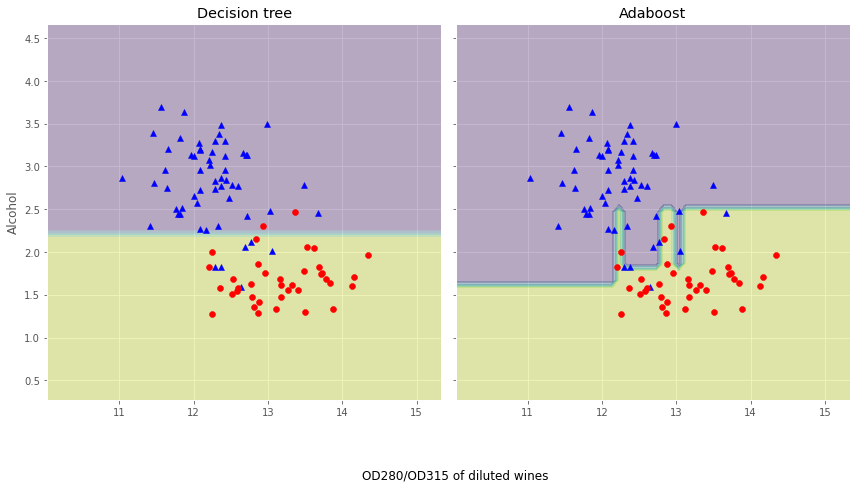

In [7]:
# 画出单层决策树与Adaboost的决策边界：
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',sharey='row',figsize=(12, 6))
for idx, clf, tt in zip([0, 1],[tree, ada],['Decision tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.show()

## 前向分布算法

**(1) 加法模型：**                                 
在Adaboost模型中，我们把每个基本分类器合成一个复杂分类器的方法是每个基本分类器的加权和，即：$f(x)=\sum_{m=1}^{M} \beta_{m} b\left(x ; \gamma_{m}\right)$，其中，$b\left(x ; \gamma_{m}\right)$为即基本分类器，$\gamma_{m}$为基本分类器的参数，$\beta_m$为基本分类器的权重，显然这与第二章所学的加法模型。为什么这么说呢？大家把$b(x ; \gamma_{m})$看成是即函数即可。                       
在给定训练数据以及损失函数$L(y, f(x))$的条件下，学习加法模型$f(x)$就是：                        
$$
\min _{\beta_{m}, \gamma_{m}} \sum_{i=1}^{N} L\left(y_{i}, \sum_{m=1}^{M} \beta_{m} b\left(x_{i} ; \gamma_{m}\right)\right)
$$                      
通常这是一个复杂的优化问题，很难通过简单的凸优化的相关知识进行解决。前向分步算法可以用来求解这种方式的问题，它的基本思路是：因为学习的是加法模型，如果从前向后，每一步只优化一个基函数及其系数，逐步逼近目标函数，那么就可以降低优化的复杂度。具体而言，每一步只需要优化：                    
$$
\min _{\beta, \gamma} \sum_{i=1}^{N} L\left(y_{i}, \beta b\left(x_{i} ; \gamma\right)\right)
$$                                   
**(2) 前向分步算法：**                              
给定数据集$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}$，$x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}$，$y_{i} \in \mathcal{Y}=\{+1,-1\}$。损失函数$L(y, f(x))$，基函数集合$\{b(x ; \gamma)\}$，我们需要输出加法模型$f(x)$。                         
   - 初始化：$f_{0}(x)=0$                           
   - 对m = 1,2,...,M:                     
      - (a) 极小化损失函数：
      $$
      \left(\beta_{m}, \gamma_{m}\right)=\arg \min _{\beta, \gamma} \sum_{i=1}^{N} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+\beta b\left(x_{i} ; \gamma\right)\right)
      $$                        
      得到参数$\beta_{m}$与$\gamma_{m}$                                           
      - (b) 更新：                          
      $$
      f_{m}(x)=f_{m-1}(x)+\beta_{m} b\left(x ; \gamma_{m}\right)
      $$                                       
   - 得到加法模型：                           
   $$
   f(x)=f_{M}(x)=\sum_{m=1}^{M} \beta_{m} b\left(x ; \gamma_{m}\right)
   $$                                                     

这样，前向分步算法将同时求解从m=1到M的所有参数$\beta_{m}$，$\gamma_{m}$的优化问题简化为逐次求解各个$\beta_{m}$，$\gamma_{m}$的问题。                           
**(3) 前向分步算法与Adaboost的关系：**                                 
由于这里不是我们的重点，我们主要阐述这里的结论，不做相关证明，具体的证明见李航老师的《统计学习方法》第八章的3.2节。Adaboost算法是前向分步算法的特例，Adaboost算法是由基本分类器组成的加法模型，损失函数为指数损失函数。

## 梯度提升决策树（GBDT）
(1) 基于残差学习的提升树算法：                                      
在前面的学习过程中，我们一直讨论的都是分类树，比如Adaboost算法，并没有涉及回归的例子。在上一小节我们提到了一个加法模型+前向分步算法的框架，那能否使用这个框架解决回归的例子呢？答案是肯定的。接下来我们来探讨下如何使用加法模型+前向分步算法的框架实现回归问题。                                 
在使用加法模型+前向分步算法的框架解决问题之前，我们需要首先确定框架内使用的基函数是什么，在这里我们使用决策树分类器。前面第二章我们已经学过了回归树的基本原理，树算法最重要是寻找最佳的划分点，分类树用纯度来判断最佳划分点使用信息增益（ID3算法），信息增益比（C4.5算法），基尼系数（CART分类树）。但是在回归树中的样本标签是连续数值，可划分点包含了所有特征的所有可取的值。所以再使用熵之类的指标不再合适，取而代之的是平方误差，它能很好的评判拟合程度。基函数确定了以后，我们需要确定每次提升的标准是什么。回想Adaboost算法，在Adaboost算法内使用了分类错误率修正样本权重以及计算每个基本分类器的权重，那回归问题没有分类错误率可言，也就没办法在这里的回归问题使用了，因此我们需要另辟蹊径。模仿分类错误率，我们用每个样本的残差表示每次使用基函数预测时没有解决的那部分问题。因此，我们可以得出如下算法：                                  
输入数据集$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}, x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}, y_{i} \in \mathcal{Y} \subseteq \mathbf{R}$，输出最终的提升树$f_{M}(x)$                             
   - 初始化$f_0(x) = 0$                        
   - 对m = 1,2,...,M：                  
      - 计算每个样本的残差:$r_{m i}=y_{i}-f_{m-1}\left(x_{i}\right), \quad i=1,2, \cdots, N$                                    
      - 拟合残差$r_{mi}$学习一棵回归树，得到$T\left(x ; \Theta_{m}\right)$                        
      - 更新$f_{m}(x)=f_{m-1}(x)+T\left(x ; \Theta_{m}\right)$
   - 得到最终的回归问题的提升树：$f_{M}(x)=\sum_{m=1}^{M} T\left(x ; \Theta_{m}\right)$  

(2) 梯度提升决策树算法(GBDT)：                                
提升树利用加法模型和前向分步算法实现学习的过程，当损失函数为平方损失和指数损失时，每一步优化是相当简单的，也就是我们前面探讨的提升树算法和Adaboost算法。但是对于一般的损失函数而言，往往每一步的优化不是那么容易，针对这一问题，我们得分析问题的本质，也就是是什么导致了在一般损失函数条件下的学习困难。对比以下损失函数：                          
$$
\begin{array}{l|l|l}
\hline \text { Setting } & \text { Loss Function } & -\partial L\left(y_{i}, f\left(x_{i}\right)\right) / \partial f\left(x_{i}\right) \\
\hline \text { Regression } & \frac{1}{2}\left[y_{i}-f\left(x_{i}\right)\right]^{2} & y_{i}-f\left(x_{i}\right) \\
\hline \text { Regression } & \left|y_{i}-f\left(x_{i}\right)\right| & \operatorname{sign}\left[y_{i}-f\left(x_{i}\right)\right] \\
\hline \text { Regression } & \text { Huber } & y_{i}-f\left(x_{i}\right) \text { for }\left|y_{i}-f\left(x_{i}\right)\right| \leq \delta_{m} \\
& & \delta_{m} \operatorname{sign}\left[y_{i}-f\left(x_{i}\right)\right] \text { for }\left|y_{i}-f\left(x_{i}\right)\right|>\delta_{m} \\
& & \text { where } \delta_{m}=\alpha \text { th-quantile }\left\{\left|y_{i}-f\left(x_{i}\right)\right|\right\} \\
\hline \text { Classification } & \text { Deviance } & k \text { th component: } I\left(y_{i}=\mathcal{G}_{k}\right)-p_{k}\left(x_{i}\right) \\
\hline
\end{array}
$$                           
观察Huber损失函数：                            
$$
L_{\delta}(y, f(x))=\left\{\begin{array}{ll}
\frac{1}{2}(y-f(x))^{2} & \text { for }|y-f(x)| \leq \delta \\
\delta|y-f(x)|-\frac{1}{2} \delta^{2} & \text { otherwise }
\end{array}\right.
$$                                            
针对上面的问题，Freidman提出了梯度提升算法(gradient boosting)，这是利用最速下降法的近似方法，利用损失函数的负梯度在当前模型的值$-\left[\frac{\partial L\left(y, f\left(x_{i}\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f(x)=f_{m-1}(x)}$作为回归问题提升树算法中的残差的近似值，拟合回归树。**与其说负梯度作为残差的近似值，不如说残差是负梯度的一种特例。**                   
以下开始具体介绍梯度提升算法：                      
输入训练数据集$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}, x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}, y_{i} \in \mathcal{Y} \subseteq \mathbf{R}$和损失函数$L(y, f(x))$，输出回归树$\hat{f}(x)$                              
   - 初始化$f_{0}(x)=\arg \min _{c} \sum_{i=1}^{N} L\left(y_{i}, c\right)$                     
   - 对于m=1,2,...,M：                   
      - 对i = 1,2,...,N计算：$r_{m i}=-\left[\frac{\partial L\left(y_{i}, f\left(x_{i}\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f(x)=f_{m-1}(x)}$                
      - 对$r_{mi}$拟合一个回归树，得到第m棵树的叶结点区域$R_{m j}, j=1,2, \cdots, J$                           
      - 对j=1,2,...J，计算：$c_{m j}=\arg \min _{c} \sum_{x_{i} \in R_{m j}} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+c\right)$                      
      - 更新$f_{m}(x)=f_{m-1}(x)+\sum_{j=1}^{J} c_{m j} I\left(x \in R_{m j}\right)$                    
   - 得到回归树：$\hat{f}(x)=f_{M}(x)=\sum_{m=1}^{M} \sum_{j=1}^{J} c_{m j} I\left(x \in R_{m j}\right)$

In [1]:
# 代码实例
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

'''
GradientBoostingRegressor参数解释：
loss：{‘ls’, ‘lad’, ‘huber’, ‘quantile’}, default=’ls’：‘ls’ 指最小二乘回归. ‘lad’ (最小绝对偏差) 是仅基于输入变量的顺序信息的高度鲁棒的损失函数。. ‘huber’ 是两者的结合. ‘quantile’允许分位数回归（用于alpha指定分位数）
learning_rate：学习率缩小了每棵树的贡献learning_rate。在learning_rate和n_estimators之间需要权衡。
n_estimators：要执行的提升次数。
subsample：用于拟合各个基础学习者的样本比例。如果小于1.0，则将导致随机梯度增强。subsample与参数n_estimators。选择会导致方差减少和偏差增加。subsample < 1.0
criterion：{'friedman_mse'，'mse'，'mae'}，默认='friedman_mse'：“ mse”是均方误差，“ mae”是平均绝对误差。默认值“ friedman_mse”通常是最好的，因为在某些情况下它可以提供更好的近似值。
min_samples_split：拆分内部节点所需的最少样本数
min_samples_leaf：在叶节点处需要的最小样本数。
min_weight_fraction_leaf：在所有叶节点处（所有输入样本）的权重总和中的最小加权分数。如果未提供sample_weight，则样本的权重相等。
max_depth：各个回归模型的最大深度。最大深度限制了树中节点的数量。调整此参数以获得最佳性能；最佳值取决于输入变量的相互作用。
min_impurity_decrease：如果节点分裂会导致杂质的减少大于或等于该值，则该节点将被分裂。
min_impurity_split：提前停止树木生长的阈值。如果节点的杂质高于阈值，则该节点将分裂
max_features{‘auto’, ‘sqrt’, ‘log2’}，int或float：寻找最佳分割时要考虑的功能数量：

如果为int，则max_features在每个分割处考虑特征。

如果为float，max_features则为小数，并 在每次拆分时考虑要素。int(max_features * n_features)

如果“auto”，则max_features=n_features。

如果是“ sqrt”，则max_features=sqrt(n_features)。

如果为“ log2”，则为max_features=log2(n_features)。

如果没有，则max_features=n_features。
'''

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
mean_squared_error(y_test, est.predict(X_test))

5.009154859960321

In [2]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X, y = make_regression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.43848663277068134